#  Trader Performance vs Bitcoin Market Sentiment with Machine Learning


In [ ]:
#  Load Libraries and Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

trader_df = pd.read_csv('historical_data.csv')
sentiment_df = pd.read_csv('fear_greed_index.csv')

In [ ]:
#  Preprocessing
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'],format='%d-%m-%Y %H:%M')
trader_df['Date'] = trader_df['Timestamp IST'].dt.date
trader_df['Date'] = pd.to_datetime(trader_df['Date'])
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'], format='%d-%m-%Y')

def simplify_sentiment(classification):
    if 'fear' in classification.lower():
        return 'Fear'
    else:
        return 'Greed'

sentiment_df['Simplified'] = sentiment_df['Classification'].apply(simplify_sentiment)

merged_df = pd.merge(trader_df, sentiment_df[['Date', 'Simplified']], on='Date', how='left')
merged_df.dropna(subset=['Simplified'], inplace=True)

In [ ]:
#  Feature Engineering
merged_df['Is_Buy'] = merged_df['Side'].str.upper() == 'BUY'
merged_df['PnL_per_token'] = merged_df['Closed PnL'] / merged_df['Size Tokens'].replace(0, np.nan)
merged_df['Trade_Aggressiveness'] = merged_df['Size USD'] * merged_df['Is_Buy'].replace({True: 1, False: -1})

# Define target: Profit if PnL > 0
merged_df['Profitable'] = (merged_df['Closed PnL'] > 0).astype(int)

C:\Users\sahaj\AppData\Local\Temp\ipykernel_33736\456052794.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['Trade_Aggressiveness'] = merged_df['Size USD'] * merged_df['Is_Buy'].replace({True: 1, False: -1})


In [ ]:
#  ML Modeling
# Select features
features = ['Size Tokens', 'Size USD', 'Fee', 'Start Position', 'Is_Buy', 'Trade_Aggressiveness', 'Simplified']
df_model = merged_df[features + ['Profitable']].dropna()

# Encode categorical
le = LabelEncoder()
df_model['Sentiment_Encoded'] = le.fit_transform(df_model['Simplified'])

# Final feature set
X = df_model[['Size Tokens', 'Size USD', 'Fee', 'Start Position', 'Is_Buy', 'Trade_Aggressiveness', 'Sentiment_Encoded']]
y = df_model['Profitable']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [ ]:
#  Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[23056  1792]
 [  361 17035]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     24848
           1       0.90      0.98      0.94     17396

    accuracy                           0.95     42244
   macro avg       0.94      0.95      0.95     42244
weighted avg       0.95      0.95      0.95     42244



C:\Users\sahaj\AppData\Local\Temp\ipykernel_33736\4271611232.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


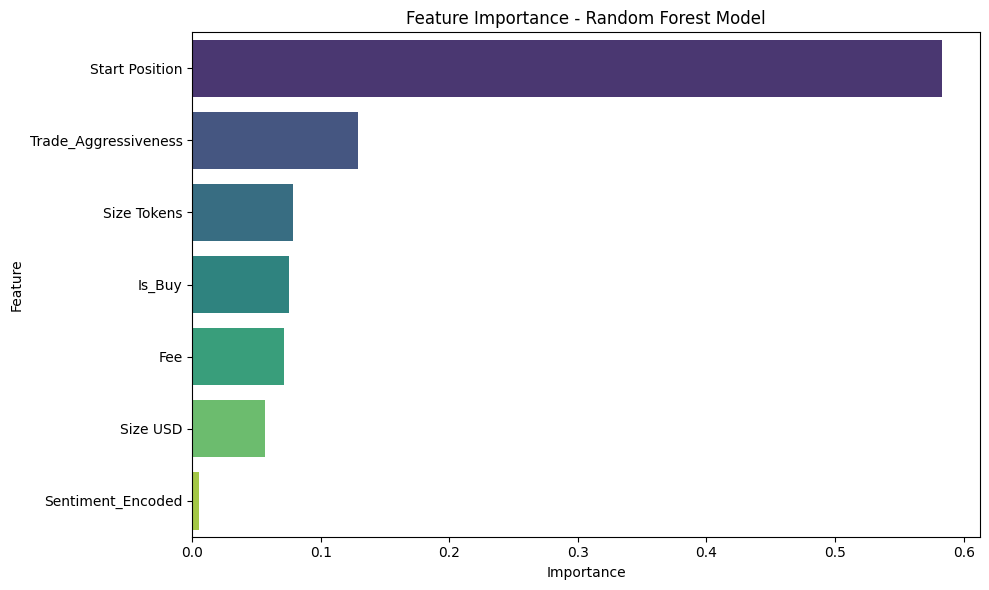

In [ ]:
#  Feature Importance
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance - Random Forest Model')
plt.tight_layout()
plt.show()

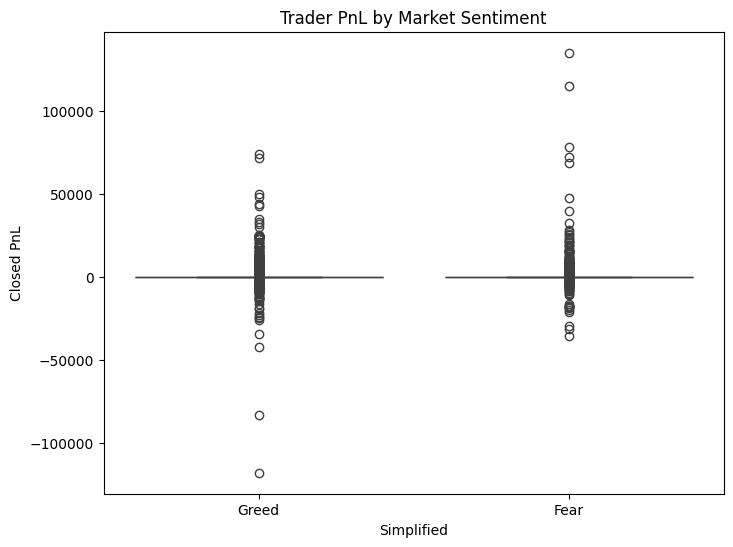

In [ ]:
#  Visual Analysis
plt.figure(figsize=(8, 6))
sns.boxplot(data=merged_df, x='Simplified', y='Closed PnL')
plt.title('Trader PnL by Market Sentiment')
plt.show()

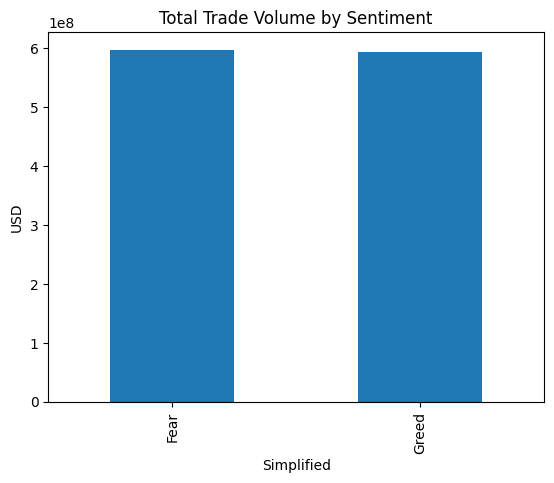

In [9]:
# Bar chart: Total volume
volume_by_sentiment = merged_df.groupby('Simplified')['Size USD'].sum()
volume_by_sentiment.plot(kind='bar', title='Total Trade Volume by Sentiment', ylabel='USD')
plt.show()

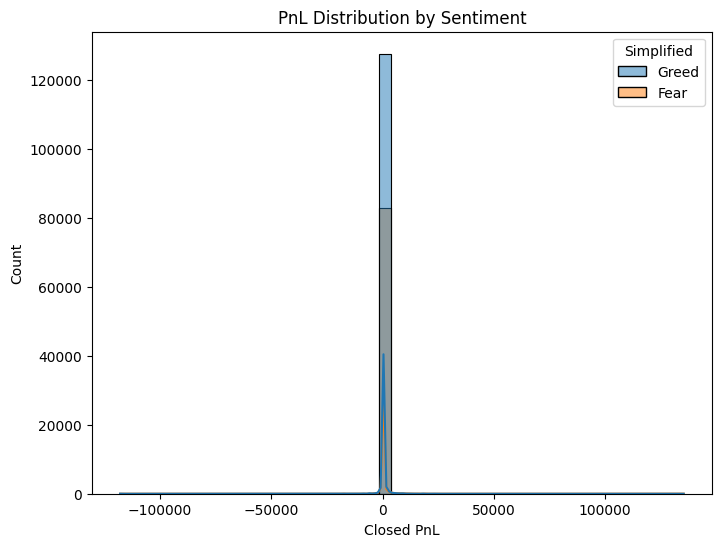

In [10]:
# PnL Distribution Histogram
plt.figure(figsize=(8, 6))
sns.histplot(data=merged_df, x='Closed PnL', hue='Simplified', kde=True, bins=50)
plt.title('PnL Distribution by Sentiment')
plt.show()

In [ ]:
#  Statistical Summary
stats = merged_df.groupby('Simplified').agg({
    'Closed PnL': ['mean', 'median', 'std'],
    'Size USD': ['sum', 'mean'],
    'Fee': 'mean'
})
print(stats)

           Closed PnL                         Size USD                    Fee
                 mean median         std           sum         mean      mean
Simplified                                                                   
Fear        49.212077    0.0  990.875398  5.978091e+08  7182.011019  1.397763
Greed       48.118246    0.0  867.308701  5.932897e+08  4635.764077  1.011897
